# 프로젝트 : 폐렴 진단기 성능 개선

### 루브릭

|순번|평가문항|상세기준|
|:--|:--|:--|
|1|의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2|데이터 준비, 모델 구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3|실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

# 1차 폐렴진단 : Baseline 커널 기반

## 1) 실험환경 Set-up

- 거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
# 필요한 패키지
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 필요한 변수 생성

# 데이터를 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/exploration/E11/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/exploration/E11/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/exploration/E11/chest_xray/data/test/*/*'

In [3]:
# 프로젝트를 진행할 때 아래 두 변수를 변경 해보세요.
BATCH_SIZE = 16
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
# tf.io.gfile.glob(불러올 파일 위치)
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# 파일 개수
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


## 2) 데이터 전처리

### 학습, 검증 데이터 재분리하기

In [5]:
# train과 val에 있는 데이터를 모은 다음 8:2 비율로 재분할 하기

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)  # 난수를 예측 가능하도록 만든다.
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 체크해봅니다.
print(f'Nomal image path \n{filenames[0]}')
print(f'Pneumonia image path \n{filenames[2000]}')

# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in rraining set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Nomal image path 
/aiffel/aiffel/exploration/E11/chest_xray/data/train/NORMAL/IM-0582-0001.jpeg
Pneumonia image path 
/aiffel/aiffel/exploration/E11/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg
Normal images count in rraining set: 1070
Pneumonia images count in training set: 3115


In [7]:
# tf.data 인스턴스 만들기
# tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨 데이터 만들기

현재 이미지에는 라벨 데이터가 따로 없지만, 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만든다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)   # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞는 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이즈와 라벨이 잘 들어갔는지 확인하기
for image, label in train_ds.take(1):  # take(1) : 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.

- __`prepare_for_training()`__ 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

  
- __`shuffle()`__을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

  
- __`repeat()`__를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

  
- __`batch()`__를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

  
- __`prefetch()`__를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3) 데이터 시각화

- 학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여주는 함수
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

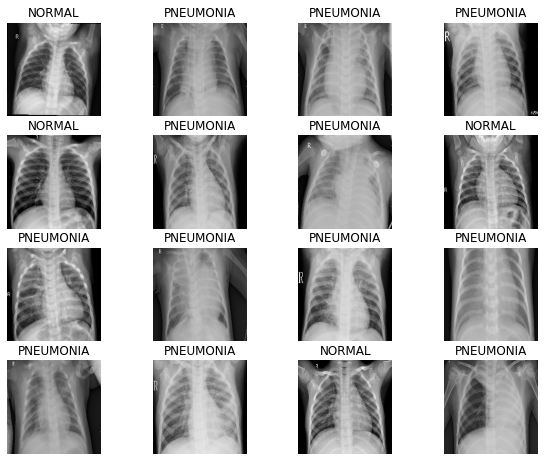

In [16]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4) CNN 모델링

- 의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.  
  
  
- 그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5) 데이터 imbalance 처리

- 실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [20]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6) 모델 훈련

- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
261/261 [==============================] - 55s 139ms/step - loss: 0.4884 - accuracy: 0.7321 - precision: 0.9249 - recall: 0.6960 - val_loss: 0.6177 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 34s 130ms/step - loss: 0.2570 - accuracy: 0.8991 - precision: 0.9691 - recall: 0.8946 - val_loss: 1.7579 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 34s 130ms/step - loss: 0.1976 - accuracy: 0.9196 - precision: 0.9783 - recall: 0.9128 - val_loss: 0.9269 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 34s 129ms/step - loss: 0.1725 - accuracy: 0.9328 - precision: 0.9821 - recall: 0.9269 - val_loss: 0.1077 - val_accuracy: 0.9596 - val_precision: 0.9826 - val_recall: 0.9619
Epoch 5/15
261/261 [==============================] - 34s 129ms/step - loss: 0.1524 - accura

## 7) 결과 확인 및 시각화

- 테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

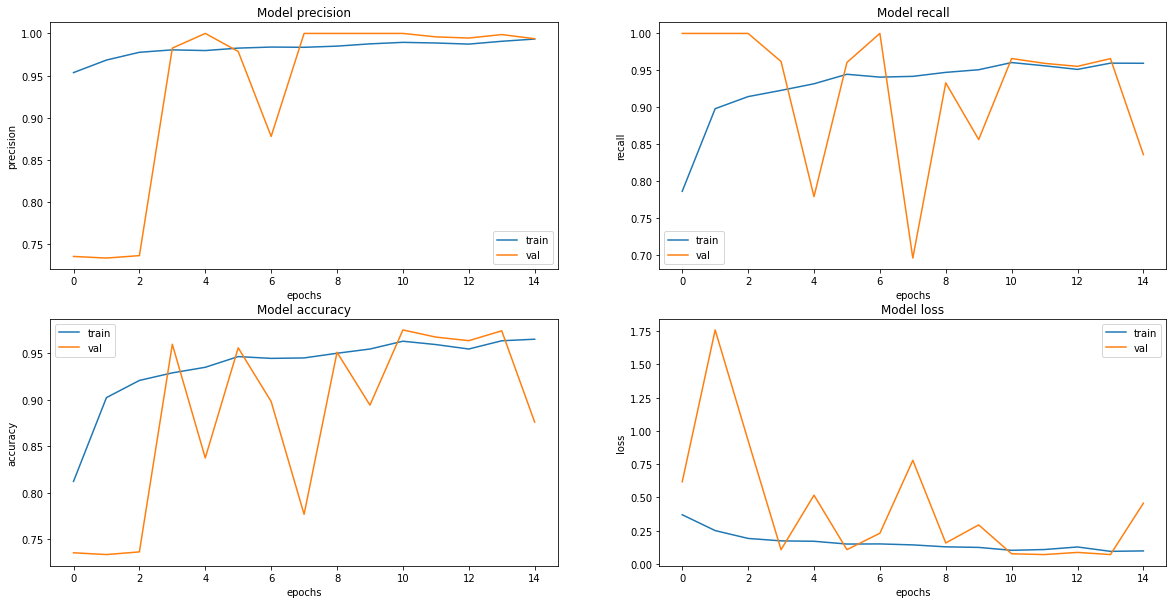

In [23]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.4883 - accuracy: 0.8670 - precision: 0.8886 - recall: 0.9000
Loss: 0.48825401067733765,
Accuracy: 0.8669871687889099,
Precision: 0.8886076211929321,
Recall: 0.8999999761581421


# 2차 폐렴진단 : EarlyStopping 추가

### 모델 훈련

In [26]:
# 학습 결과 5회가 넘어가면 val_loss가 줄었다가 늘어나고 다시 줄어드는 현상이 
# 반복적으로 발생해서 Earlystopping을 설정해보겠습니다.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  # val_loss가 증가하면 학습을 조기 종료함(EarlyStopping)

In [27]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [29]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
        callbacks = [es]
    )

Epoch 1/15
261/261 [==============================] - 40s 132ms/step - loss: 0.1325 - accuracy: 0.9504 - precision: 0.9863 - recall: 0.9466 - val_loss: 0.1054 - val_accuracy: 0.9625 - val_precision: 0.9932 - val_recall: 0.9554
Epoch 2/15
261/261 [==============================] - 34s 130ms/step - loss: 0.1291 - accuracy: 0.9562 - precision: 0.9870 - recall: 0.9537 - val_loss: 0.1151 - val_accuracy: 0.9500 - val_precision: 0.9904 - val_recall: 0.9412
Epoch 3/15
261/261 [==============================] - 34s 130ms/step - loss: 0.1081 - accuracy: 0.9574 - precision: 0.9890 - recall: 0.9534 - val_loss: 0.0988 - val_accuracy: 0.9625 - val_precision: 0.9788 - val_recall: 0.9698
Epoch 4/15
261/261 [==============================] - 34s 129ms/step - loss: 0.1049 - accuracy: 0.9605 - precision: 0.9903 - recall: 0.9562 - val_loss: 0.0815 - val_accuracy: 0.9750 - val_precision: 0.9743 - val_recall: 0.9921
Epoch 5/15
261/261 [==============================] - 34s 129ms/step - loss: 0.1092 - accura

### 결과 시각화 및 모델 평가

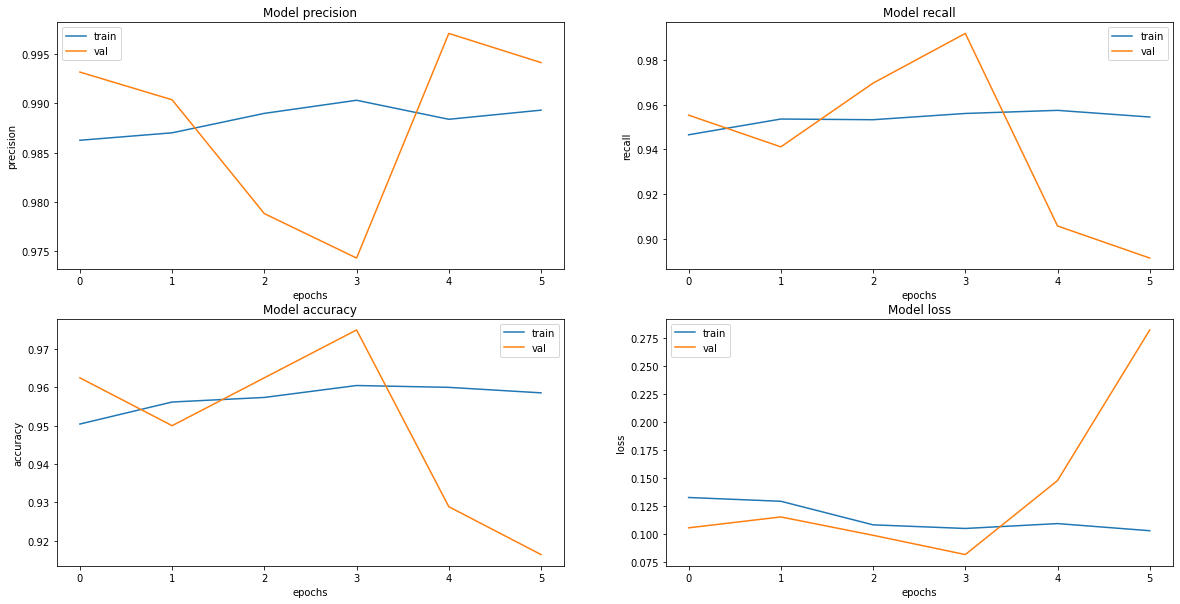

In [30]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.8791 - accuracy: 0.8125 - precision: 0.8095 - recall: 0.9154
Loss: 0.8791165351867676,
Accuracy: 0.8125,
Precision: 0.8095238208770752,
Recall: 0.9153845906257629


# 3차 폐렴진단 : Batch size 조절

In [32]:
BATCH_SIZE = 8
EPOCHS = 15

In [33]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [34]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"  # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)  # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32)  # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE)  # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path)   # 라벨 검출
    img = tf.io.read_file(file_path)  # 이미지 읽기
    img = decode_img(img)  # 이미지를 알맞는 형식으로 수정
    return img, label

In [35]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
# 이미지 리사이즈와 라벨이 잘 들어갔는지 확인하기
for image, label in train_ds.take(1):  # take(1) : 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [37]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [38]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [39]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [40]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [42]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [43]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 64s 76ms/step - loss: 0.6555 - accuracy: 0.6723 - precision: 0.8796 - recall: 0.6473 - val_loss: 0.9065 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 39s 74ms/step - loss: 0.3374 - accuracy: 0.8518 - precision: 0.9565 - recall: 0.8405 - val_loss: 0.3623 - val_accuracy: 0.8567 - val_precision: 0.9968 - val_recall: 0.8071
Epoch 3/15
523/523 [==============================] - 39s 74ms/step - loss: 0.2760 - accuracy: 0.8740 - precision: 0.9606 - recall: 0.8658 - val_loss: 0.1355 - val_accuracy: 0.9538 - val_precision: 0.9864 - val_recall: 0.9502
Epoch 4/15
523/523 [==============================] - 39s 75ms/step - loss: 0.2423 - accuracy: 0.9017 - precision: 0.9739 - recall: 0.8937 - val_loss: 0.1376 - val_accuracy: 0.9558 - val_precision: 0.9557 - val_recall: 0.9856
Epoch 5/15
523/523 [==============================] - 39s 74ms/step - loss: 0.2304 - accuracy: 0

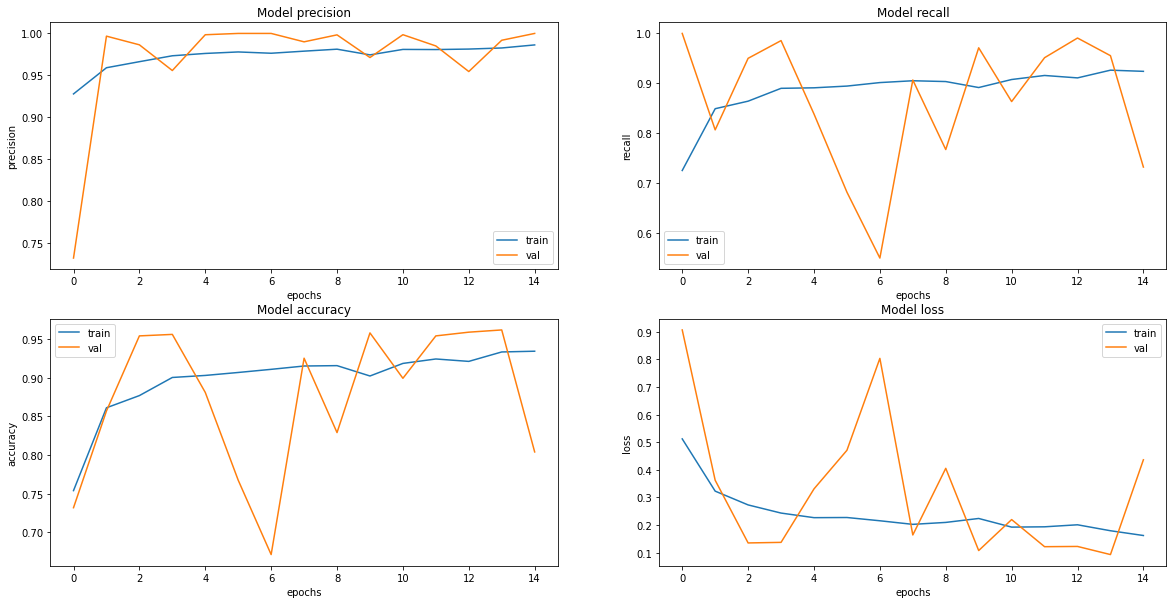

In [45]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 38ms/step - loss: 0.4169 - accuracy: 0.8109 - precision: 0.8931 - recall: 0.7923
Loss: 0.4169047474861145,
Accuracy: 0.8108974099159241,
Precision: 0.8930636048316956,
Recall: 0.7923076748847961


# 4차 폐렴진단 : Data augmentation

- 원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.  
  
  
- 이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다. 그래서 augmentation 도입은 신중해야 합니다.

In [47]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [48]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

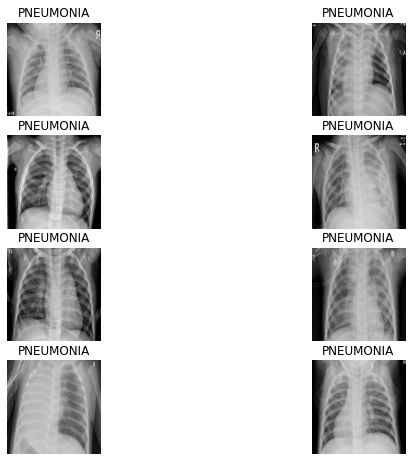

In [49]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [50]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [51]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 46s 74ms/step - loss: 0.5714 - accuracy: 0.7093 - precision: 0.9050 - recall: 0.6765 - val_loss: 0.8692 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 38s 73ms/step - loss: 0.3223 - accuracy: 0.8750 - precision: 0.9594 - recall: 0.8692 - val_loss: 8.0910 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
523/523 [==============================] - 38s 73ms/step - loss: 0.3248 - accuracy: 0.8502 - precision: 0.9520 - recall: 0.8411 - val_loss: 0.1684 - val_accuracy: 0.9442 - val_precision: 0.9549 - val_recall: 0.9699
Epoch 4/15
523/523 [==============================] - 38s 73ms/step - loss: 0.2518 - accuracy: 0.8964 - precision: 0.9708 - recall: 0.8875 - val_loss: 0.1734 - val_accuracy: 0.9385 - val_precision: 0.9464 - val_recall: 0.9712
Epoch 5/15
523/523 [==============================] - 38s 74ms/step - loss: 0.2746 - acc

### 결과 시각화 및 모델 평가

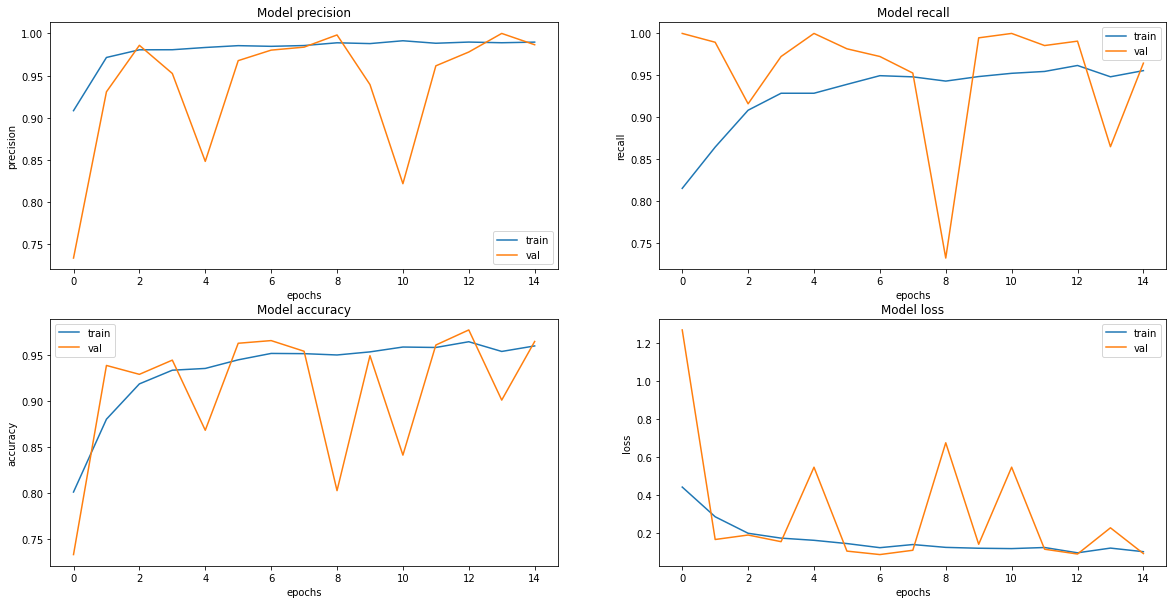

In [66]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 39ms/step - loss: 0.5508 - accuracy: 0.8061 - precision: 0.7808 - recall: 0.9590
Loss: 0.5508032441139221,
Accuracy: 0.8060897588729858,
Precision: 0.780793309211731,
Recall: 0.9589743614196777


# 5차 폐렴진단 : Batch Normalization 제거

### 모델링

In [68]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [69]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [70]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [71]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [72]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [73]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 46s 74ms/step - loss: 0.4604 - accuracy: 0.7970 - precision: 0.8974 - recall: 0.8291 - val_loss: 1.2904 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 38s 72ms/step - loss: 0.2481 - accuracy: 0.8876 - precision: 0.9780 - recall: 0.8698 - val_loss: 3.6205 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
523/523 [==============================] - 38s 72ms/step - loss: 0.2554 - accuracy: 0.8869 - precision: 0.9772 - recall: 0.8689 - val_loss: 0.1472 - val_accuracy: 0.9356 - val_precision: 0.9394 - val_recall: 0.9751
Epoch 4/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1882 - accuracy: 0.9308 - precision: 0.9815 - recall: 0.9250 - val_loss: 0.1394 - val_accuracy: 0.9538 - val_precision: 0.9497 - val_recall: 0.9895
Epoch 5/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1619 - acc

### 결과 시각화 및 모델 평가

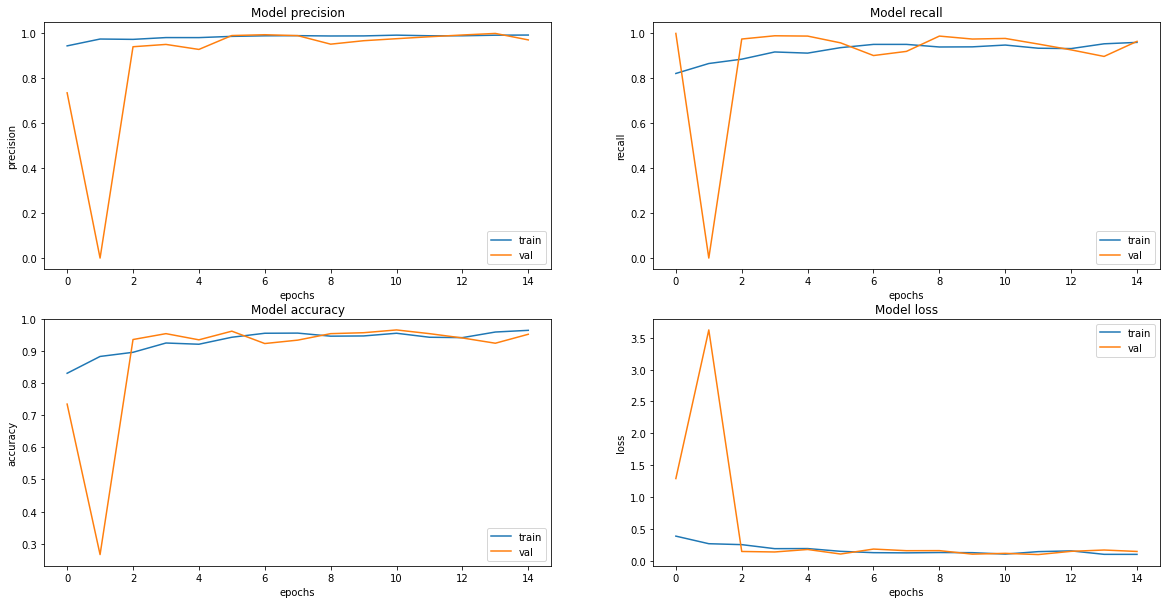

In [74]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [75]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 38ms/step - loss: 0.7574 - accuracy: 0.8061 - precision: 0.7685 - recall: 0.9872
Loss: 0.7573772072792053,
Accuracy: 0.8060897588729858,
Precision: 0.7684630751609802,
Recall: 0.9871794581413269


# 6차 폐렴진단 : Dropout 제거

### 모델링

In [76]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [77]:
def dense_block(units):  # 매개변수에서 dropout_rate를 제거 해줍니다.
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [78]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [79]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [80]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [81]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 46s 75ms/step - loss: 0.3995 - accuracy: 0.8134 - precision: 0.9531 - recall: 0.7894 - val_loss: 0.7790 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 38s 73ms/step - loss: 0.2282 - accuracy: 0.9074 - precision: 0.9757 - recall: 0.8983 - val_loss: 0.1701 - val_accuracy: 0.9356 - val_precision: 0.9295 - val_recall: 0.9869
Epoch 3/15
523/523 [==============================] - 38s 73ms/step - loss: 0.1981 - accuracy: 0.9237 - precision: 0.9765 - recall: 0.9200 - val_loss: 0.4782 - val_accuracy: 0.7750 - val_precision: 1.0000 - val_recall: 0.6937
Epoch 4/15
523/523 [==============================] - 39s 74ms/step - loss: 0.2138 - accuracy: 0.9080 - precision: 0.9779 - recall: 0.8976 - val_loss: 0.5994 - val_accuracy: 0.8029 - val_precision: 1.0000 - val_recall: 0.7317
Epoch 5/15
523/523 [==============================] - 38s 74ms/step - loss: 0.1566 - accuracy: 0

### 결과 시각화 및 모델 평가

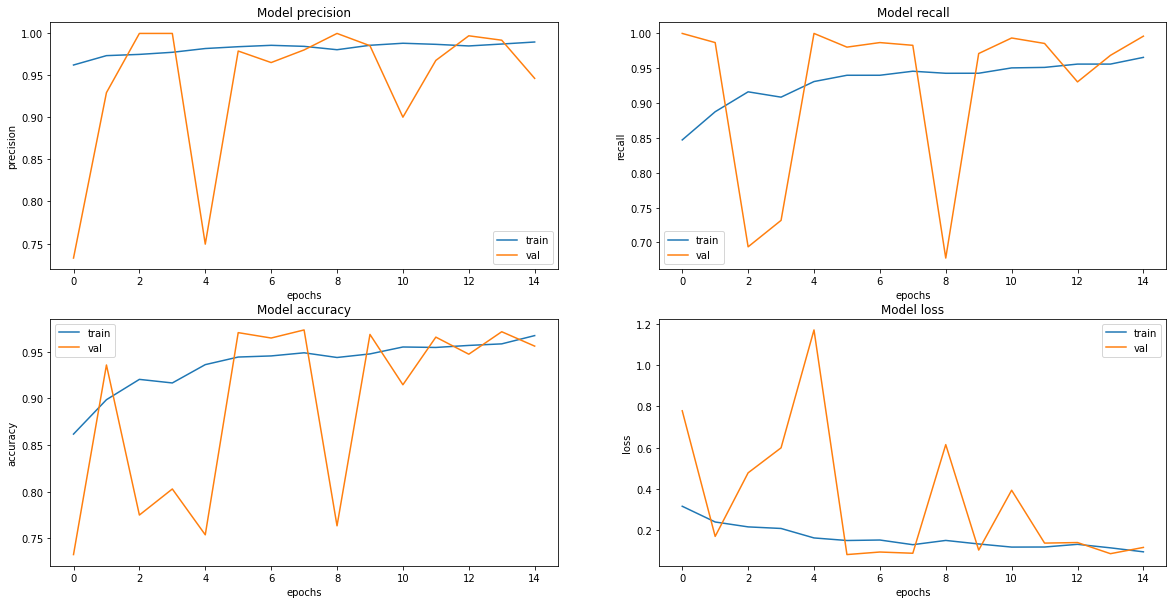

In [82]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [83]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 38ms/step - loss: 1.2389 - accuracy: 0.7003 - precision: 0.6765 - recall: 0.9974
Loss: 1.2388560771942139,
Accuracy: 0.7003205418586731,
Precision: 0.6765217185020447,
Recall: 0.9974358677864075


# 7차 폐렴진단 : BN, Dropout 모두 제거

### 모델링

In [84]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [85]:
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [86]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [87]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 평가

In [88]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [89]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 45s 73ms/step - loss: 0.3751 - accuracy: 0.8265 - precision: 0.9338 - recall: 0.8273 - val_loss: 0.5427 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1969 - accuracy: 0.9171 - precision: 0.9805 - recall: 0.9070 - val_loss: 0.3133 - val_accuracy: 0.9433 - val_precision: 0.9535 - val_recall: 0.9698
Epoch 3/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1805 - accuracy: 0.9307 - precision: 0.9793 - recall: 0.9257 - val_loss: 0.4807 - val_accuracy: 0.7538 - val_precision: 0.9980 - val_recall: 0.6654
Epoch 4/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1405 - accuracy: 0.9402 - precision: 0.9824 - recall: 0.9358 - val_loss: 0.1009 - val_accuracy: 0.9615 - val_precision: 0.9677 - val_recall: 0.9803
Epoch 5/15
523/523 [==============================] - 38s 72ms/step - loss: 0.1385 - accuracy: 0

### 결과 시각화 및 모델 평가

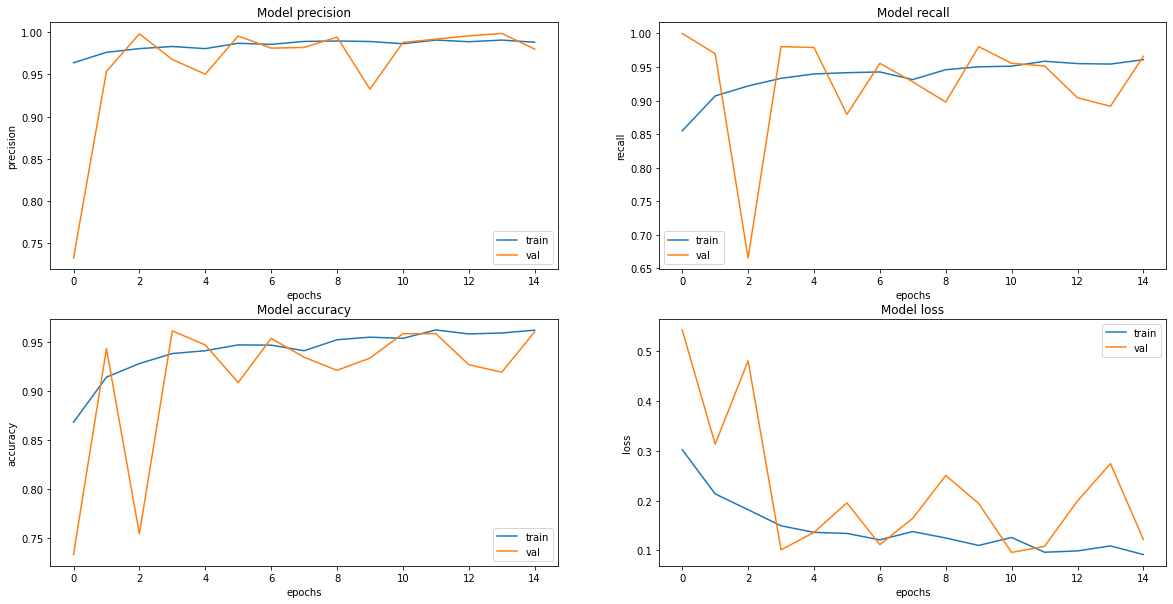

In [90]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [91]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 41ms/step - loss: 1.8578 - accuracy: 0.7564 - precision: 0.7228 - recall: 0.9897
Loss: 1.857765793800354,
Accuracy: 0.7564102411270142,
Precision: 0.7228464484214783,
Recall: 0.9897435903549194


# 8차 폐렴진단 : Dropout 비율 변경

### 모델링

In [92]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [93]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [94]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.9),
        dense_block(128, 0.7),
        dense_block(64, 0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [95]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련

In [96]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [97]:
# 모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/15
523/523 [==============================] - 47s 76ms/step - loss: 0.8750 - accuracy: 0.5267 - precision: 0.7784 - recall: 0.5128 - val_loss: 0.9972 - val_accuracy: 0.2663 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
523/523 [==============================] - 39s 74ms/step - loss: 0.7638 - accuracy: 0.5158 - precision: 0.7634 - recall: 0.5045 - val_loss: 0.7449 - val_accuracy: 0.4279 - val_precision: 0.9038 - val_recall: 0.2464
Epoch 3/15
523/523 [==============================] - 39s 75ms/step - loss: 0.6425 - accuracy: 0.5921 - precision: 0.8347 - recall: 0.5729 - val_loss: 0.7264 - val_accuracy: 0.5010 - val_precision: 0.9691 - val_recall: 0.3294
Epoch 4/15
523/523 [==============================] - 39s 74ms/step - loss: 0.5605 - accuracy: 0.6868 - precision: 0.9054 - recall: 0.6476 - val_loss: 0.4461 - val_accuracy: 0.8125 - val_precision: 0.9536 - val_recall: 0.7822
Epoch 5/15
523/523 [==============================] - 39s 75ms/step - loss: 0.5152 - acc

### 결과 시각화 및 모델 평가

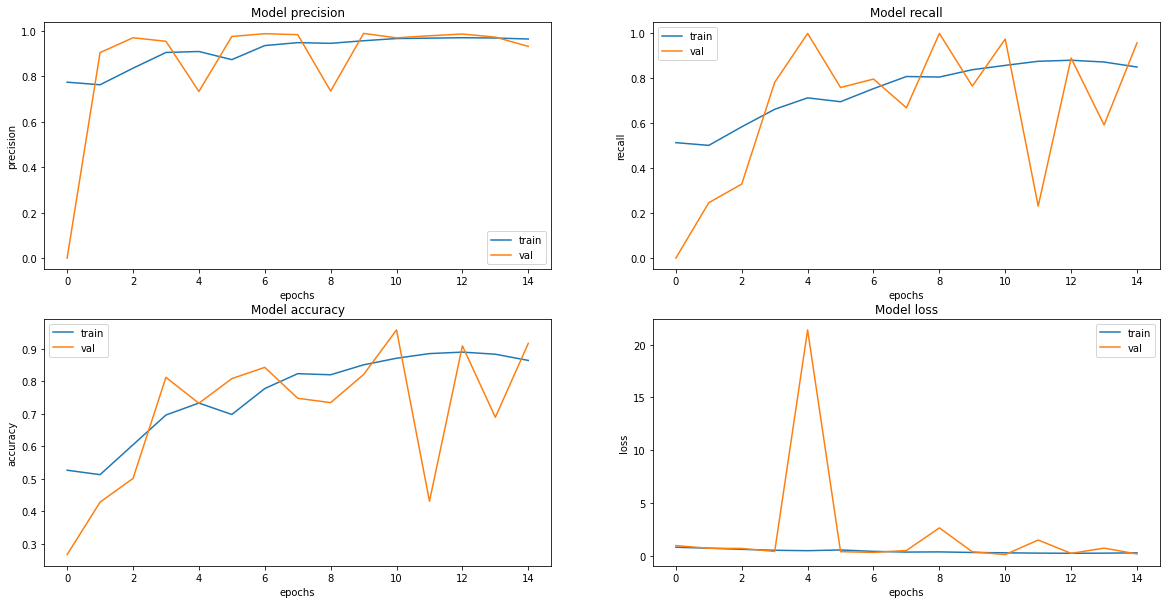

In [98]:
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [99]:
# 테스트 데이터로 모델 평가(loss, accuracy, precision, recall 값 출력)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

78/78 [==============================] - 3s 39ms/step - loss: 0.6945 - accuracy: 0.7356 - precision: 0.7184 - recall: 0.9487
Loss: 0.6944704651832581,
Accuracy: 0.7355769276618958,
Precision: 0.7184466123580933,
Recall: 0.9487179517745972


# 결론 : 성능 개선을 위해 노력한 부분

### 1. Batch_size, Epochs 변경

- __Epochs__ : 학습횟수가 5회를 넘어가면 val_loss가 줄어들었다 늘어났다를 반복해서 직전 노드에서 배웠던 Earlystopping을 사용해 보았다. 학습 횟수가 5~9회 사이로 종료되었는데 학습횟수가 부족했는지 accuracy 감소하였으나 recall은 소폭 증가하였다. 병을 진단해야하는 만큼 recall이 증가한 부분은 유의미하지 않을까? 하지만 25번의 학습 횟수는 너무 많은 것 같아 15회로 고정하고 다른 방식으로 학습을 진행하였다.  
  
  
- __Batch_size__ : Batch_size 변경이 정확도에 어떤 영향을 미치는지 확인하기 위해 16에서 8로 조정하여 학습을 진행시켰다. 결과는 accuracy, recall 모두 감소하였다.

### 2. Data Augmentation

- __이미지 좌우반전을 통한 augmentation 진행__ : 시각화를 한 폐 사진을 보니 성공적으로 augmentation이 진행된 것 같다. 하지만 accuracy는 감소 하였다. 반면에 판단 결과에 대한 정확성을 요구하는 recall은 recall은 95% 이상으로 증가한 부분이 인상적이었다.

### 3. Model Architecture 변경

- __BatchNormalization, Dropout 제거 및 Dropout 비율 변경__ :  Epochs 변경, Data Augmentation을 진행하여도 accuracy는 개선되지 못했으나, 모두 recall 값은 증가하였다. 사실 이 수치가 맞게 나온건지는 잘 모르겠다.
  
  
- __기타사항__ : Dense 부분에서 dropout을 삭제하였으나 모델 훈련 시 에러가 발생하여 확인 해보니 모델링 함수 부분에서 매개변수 중 하나인 dropout_rate 를 삭제해주지 않아 에러가 발생했던 부분을 바로잡아 훈련을 진행하였다.

### 4. 최종 진달 결과 요약

|구분|1차|2차|3차|4차|5차|6차|7차|8차|
|--|--|--|--|--|--|--|--|--|
|accuracy|0.87|0.81|0.81|0.81|0.81|0.70|0.76|0.74|
|recall|0.90|0.92|0.79|0.96|0.99|1.00|0.99|0.95|

- 수치상으로 __accuracy는 baseline 모델__이 가장 높게 나왔고, __recall은 model architecture 변경__을 통해 BN, Dropout 조건을 변경해준 부분에서 높게 나왔다.

# 회고

- 프로젝트에서 제시하는 여러 방법으로 정확도를 높이기 위해 학습을 진행하였다.  
  

- 첫 번째로 학습 횟수, 배치 사이즈, 모델 아키텍쳐 등을 변경하여 정확도를 높이는 부분이 어렵다고 느껴진다. 대체적으로 baseline에서 제시하고 있는 모델이 가장 테스트 결과가 높게 나왔다.  
  
    
- 두 번째로 같은 데이터를 동일한 조건으로 모델을 훈련시킬 때마다 테스트 결과 정확도가 다르게 나온다는 부분이었다. 어제까지만 하더라도 모델 훈련 시 최고로 높은 정확도가 81%였는데 마지막으로 돌린 정확도는 86%가 넘었다. 동일한 조건으로 모델을 훈련 시켰을때 테스트 결과의 정확도가 79~86%를 왔다 갔다 하였다.  
  
  
- 세 번째로 성능 개선을 위해 시도해 볼 수 있는 방법이 무궁무진 한 것 같다. 성능 개선을 위해 학습 횟수 변경, augmentation, model architectecture 변경 등을 차례대로 한가지씩 진행해보았는데 이러한 조건 들은 조합해서 학습을 진행시킬 수 있을 것이다. 시간 관계 상 이러한 방식을 모두 테스트 해보지는 못한 부분이 아쉽다. 그럼에도 불구하고 베이스 라인을 제외한 7가지 종류의 진단 결과가 나왔다.  
  
  
  
- 결국, 아직 모델 아키텍쳐 구조에 대한 이해나 직관이 부족하기 때문에 어떻게 모델이 학습되고 이러한 결과가 나오는지 이해하는데 한계가 있는 것 같다. 그리고 의료 데이터는 향후에 접할 기회가 많이 없을 것 같은 주제인데 여러가지 성능 개선에 대한 아이디어를 미리 주셔서 다양한 시도를 해볼 수 있어 좋았다.